In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# fname = []
# for j in range(3):
#     fname.append('steinmetz_part%d.npz'%j)
# alldat = np.array([])
# for j in range(len(fname)):
#     dat = np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']
#     alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat'])) 

## Loading DataSet

In [3]:
#@title Data Retrieval and Importing Libraries
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
from matplotlib import rcParams 
import numpy as np
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
alldat = np.array([])
for j in range(len(fname)):
  dat = np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))  # Stack previous alldat and dat together.

print(alldat.shape)

(39,)


In [4]:
ses = 0 #int(input())
dat = alldat[ses]

## Converting brain area into brain regions

In [5]:
lis = []
for i in range(len(alldat)):
    for j in range(len(alldat[i]['brain_area'])):
        lis.append(alldat[i]['brain_area'][j])
df = pd.DataFrame(lis,columns=['dt'])       
br = df['dt'].unique().tolist()

## We need to make a table of data containing neurons spiked

In [6]:
# This creates a list of all experiments and Neurons
neurons_fired = []
for i in range(len(dat['spks'][0,:,0])):
    temp = [0]*len(br)
    neurons_fired.append(temp)
len(neurons_fired)

214

In [7]:
# Creates a dictionary with neurons as the keys and corresponding index as values
dictionary = {}
for i in range(len(br)):
    dictionary[br[i]] = i
# dictionary

In [8]:
threshold = 10 #int(input())

## Filling the table with data

In [9]:
for k in range(len(dat['spks'][0,:,0])):
    for l in range(len(dat['spks'][:,k,:])):
        if sum(dat['spks'][:,k,50:][l]) >= threshold:
            index = dictionary.get(dat['brain_area'][l])
            neurons_fired[k][index] = 1

In [10]:
neurons_brain_area = pd.DataFrame(data = neurons_fired,index = np.arange(len(dat['spks'][0])),columns=br)

In [11]:
neurons_brain_area['response'] = dat['response']
neurons_brain_area['response'] = neurons_brain_area['response'].apply(lambda x : int(x))

## Creating brain groups

In [12]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Generalising to see for any brain region and making a function

In [13]:
def showCtx(ct):
    dat = alldat[0]
    brain_region = np.ones(len(dat['brain_area']), 'int')*(len(regions)-1)
    for i in range(len(regions)-1):
        brain_region[np.isin(dat['brain_area'], brain_groups[i])] = i

    region_p = np.unique(brain_region)  # Find unique brain_region indixes from brain_region.
    region_present = []
    for i in range(len(region_p)):
        region_present.append(regions[region_p[i]])

    lis = []
    for i in range(len(dat['brain_area'])):
        for j in range(len(brain_groups)):
            if dat['brain_area'][i] in brain_groups[j]:
                lis.append(regions[j])

    ctx_index = []
    for i in range(len(lis)):
        if lis[i] == ct:
            ctx_index.append(i)
    exp = []
    for i in range(len(dat['spks'][0])):
        exp.append("exp " + str(i))

    time = []
    for i in range(250):
        time.append(str((i+1)*10) + " ms")

    ctx = pd.DataFrame(columns=time)

    try:
        net_ctx = dat['spks'][ctx_index[0]]

        for i in range(1,len(ctx_index)):
            net_ctx += dat['spks'][ctx_index[i]]
        temp = pd.DataFrame(net_ctx,index = exp,columns=time)
        temp['response'] = dat['response']
        ctx = pd.concat([ctx,temp],axis=0)
    except:
        pass
    for m in range(1,len(alldat)):
        dat = alldat[m]
        brain_region = np.ones(len(dat['brain_area']), 'int')*(len(regions)-1)
        for i in range(len(regions)-1):
            brain_region[np.isin(dat['brain_area'], brain_groups[i])] = i

        region_p = np.unique(brain_region)  # Find unique brain_region indixes from brain_region.
        region_present = []
        for i in range(len(region_p)):
            region_present.append(regions[region_p[i]])

        lis = []
        for i in range(len(dat['brain_area'])):
            for j in range(len(brain_groups)):
                if dat['brain_area'][i] in brain_groups[j]:
                    lis.append(regions[j])

        ctx_index = []
        for i in range(len(lis)):
            if lis[i] == ct:
                ctx_index.append(i)
        try:
            net_ctx = dat['spks'][ctx_index[0]]
            for i in range(1,len(ctx_index)):
                net_ctx += dat['spks'][ctx_index[i]]

            exp = []
            for i in range(len(dat['spks'][0])):
                exp.append("exp " + str(i))

            time = []
            for i in range(250):
                time.append(str((i+1)*10) + " ms")

            temp = pd.DataFrame(net_ctx,index = exp,columns=time)
            temp['response'] = dat['response']
            ctx = pd.concat([ctx,temp],axis = 0)
        except:
            pass
    exp = []
    for i in range(len(ctx)):
        exp.append("exp " + str(i+ 1))
    ctx.index = exp
    
    gr = ctx.groupby('response')
    ctx_1 = pd.DataFrame(gr.get_group(1).drop('response',axis = 1).sum(),columns=['response']).reset_index()
    ctx_1['index'] = ctx_1['index'].apply(lambda x : int(x.split()[0]))
    ctx_0 = pd.DataFrame(gr.get_group(0).drop('response',axis = 1).sum(),columns=['response']).reset_index()
    ctx_0['index'] = ctx_0['index'].apply(lambda x : int(x.split()[0]))
    ctx_neg1 = pd.DataFrame(gr.get_group(-1).drop('response',axis = 1).sum(),columns=['response']).reset_index()
    ctx_neg1['index'] = ctx_neg1['index'].apply(lambda x : int(x.split()[0]))
    
    ## Creating the graph
    
    plt.figure(figsize=(18,7))
    plt.plot(np.array(list(ctx_1['response'])),'r',label='Left')    
    plt.plot(np.array(list(ctx_neg1['response'])),'b--',label='right')
    plt.plot(np.array(list(ctx_0['response'])),'g.',label='none')
    plt.title(ct)
    plt.ylabel('Number of neurons fired')
    plt.legend()  
    plt.show()

# We can now see how different cortex behave during responses

### "vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate"

## Visual Cortex

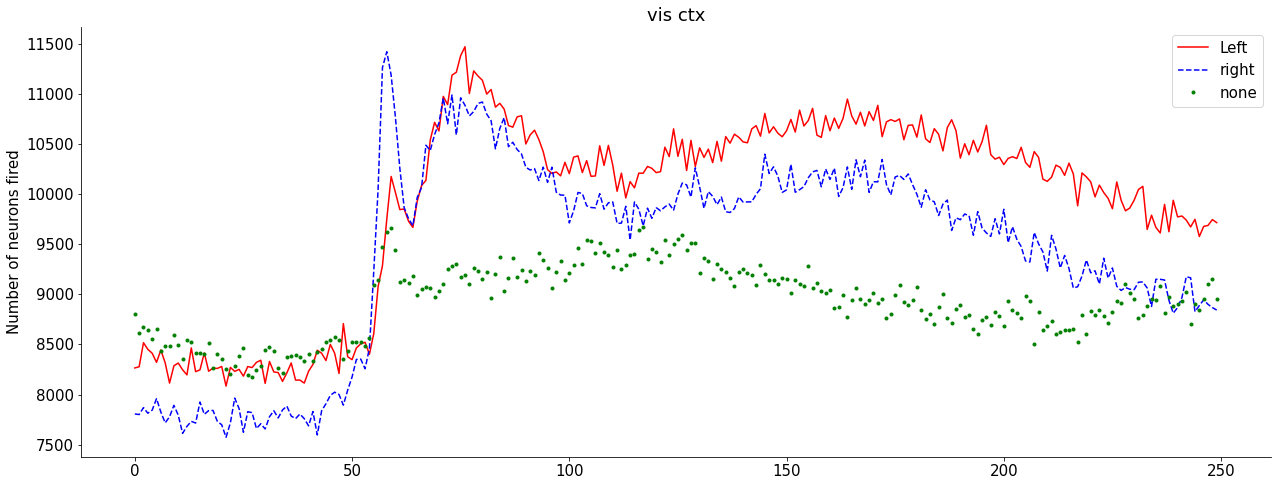

In [14]:
showCtx("vis ctx")


## 
## 
## 



## Thalamus

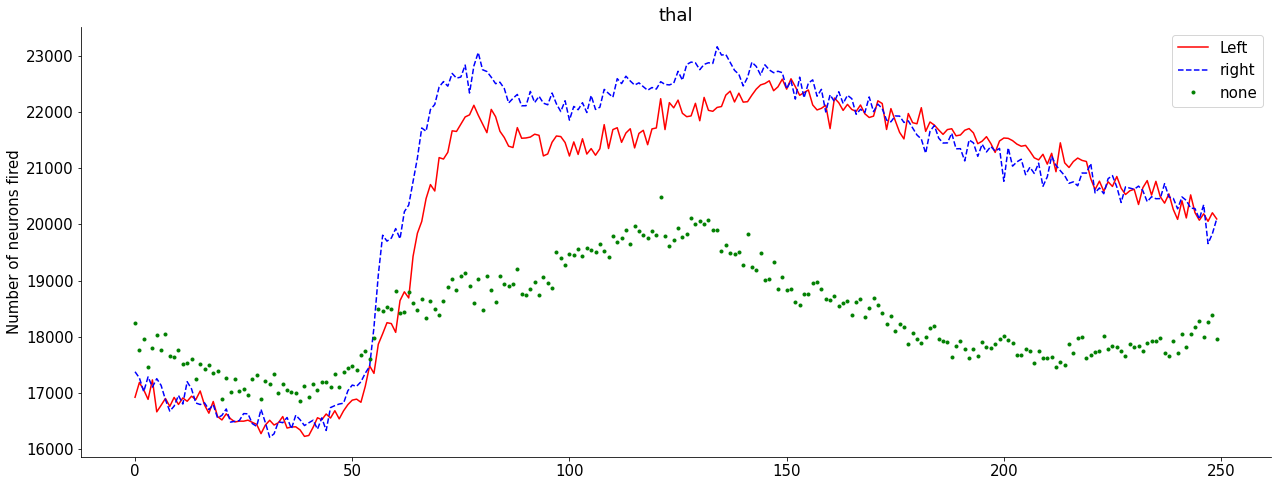

In [15]:
showCtx("thal")


## 
## 
## 

## Hippocampus

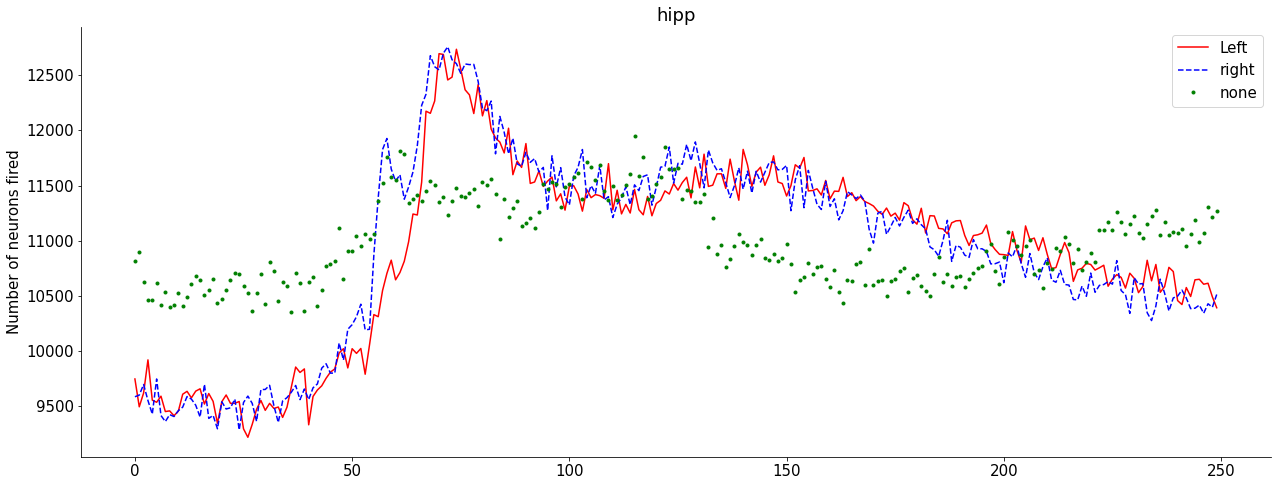

In [16]:
showCtx("hipp")

## 
## 
## 

## Basal Ganglia

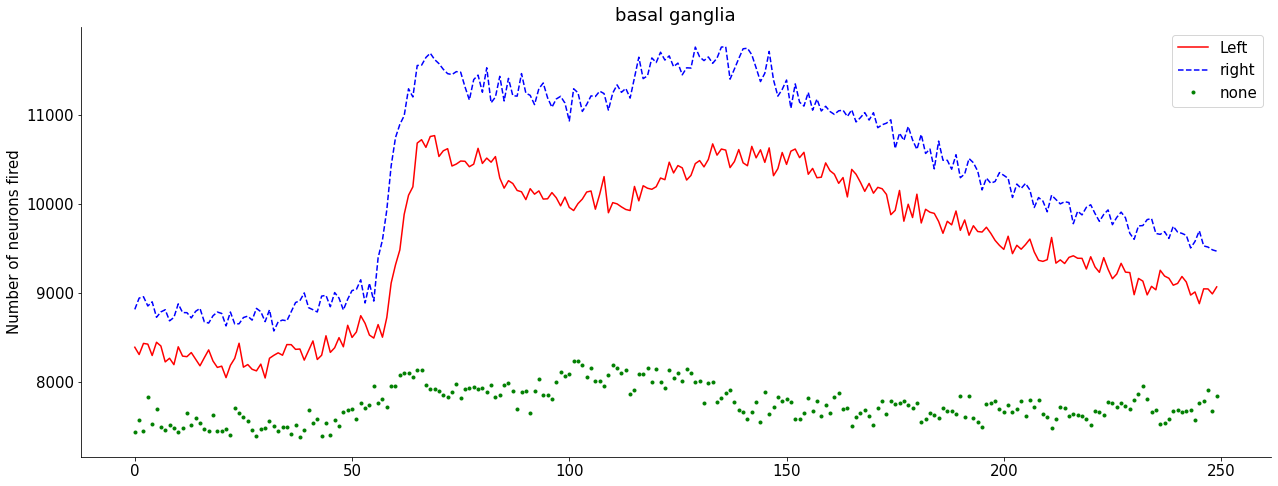

In [17]:
showCtx("basal ganglia")

## 
## 
## 

## Midbrain

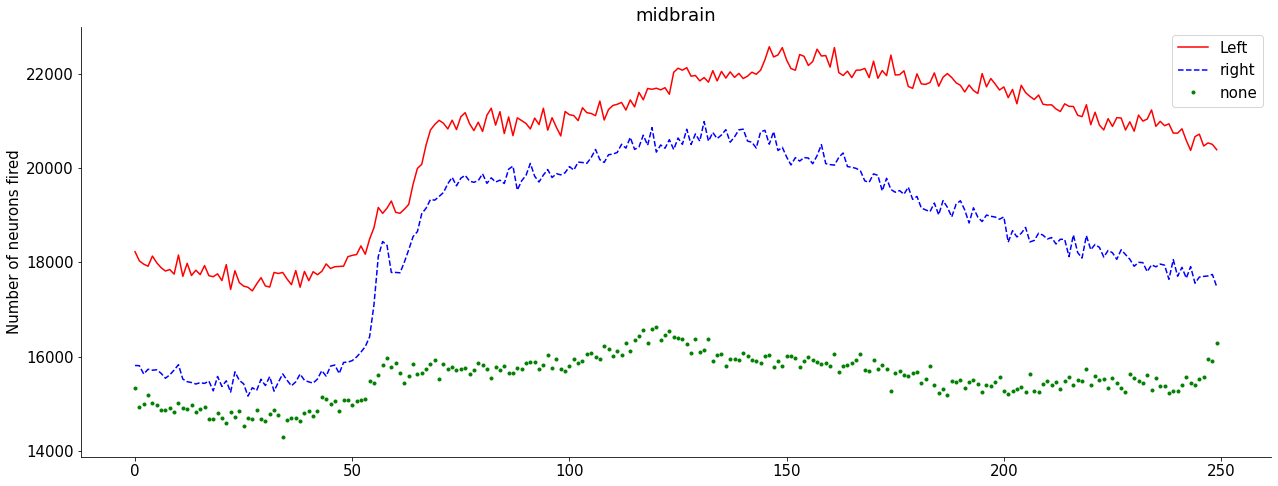

In [18]:
showCtx("midbrain")

## 
## 
## 

## Cortical Subplate

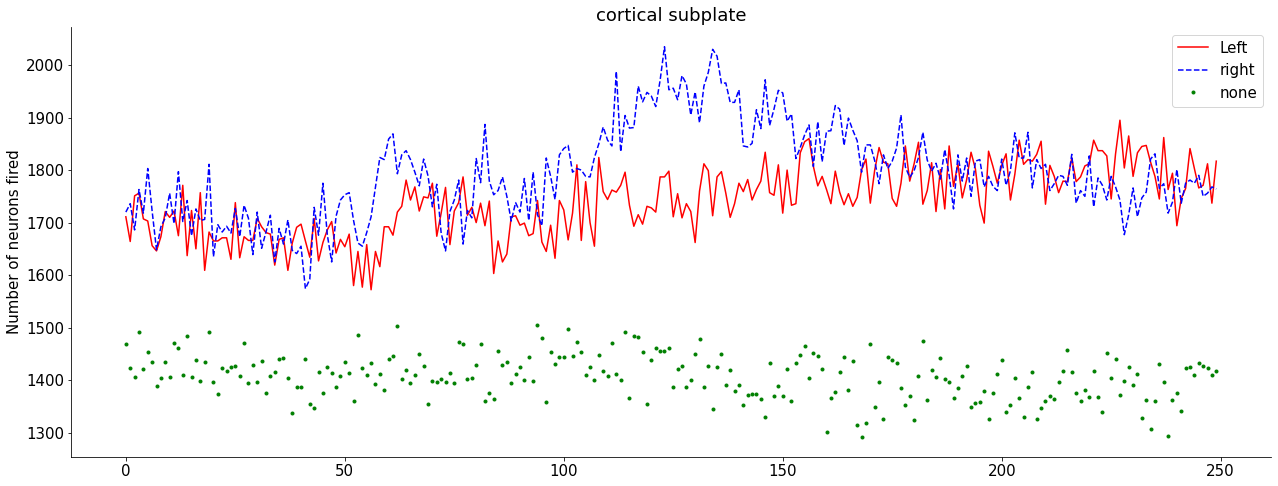

In [19]:
showCtx("cortical subplate")

## 
## Conclusion : We don't find any specific trend between different responses, so we explore it more in BCS_3
## 